In [1]:
import torchaudio
import torch
import time
import glob
import ast
import random
import librosa
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
track_ids_str = open("data/fma_small_track_ids.txt", "r").readline()
track_ids = ast.literal_eval(track_ids_str)

tracks = pd.read_csv("data/fma_metadata/tracks.csv", index_col=0, header=[0, 1])
tracks = tracks[("track")].loc[track_ids]
train_tracks = tracks.sample(frac=0.8)
test_tracks = tracks.drop(train_tracks.index)

all_genres = list(set(tracks["genre_top"]))

del track_ids, track_ids_str, tracks

In [3]:
def get_waveform(track_id):
    try:
        padded_num = f"{track_id:06}"
        waveform, sr = torchaudio.load(f"data/fma_small/{padded_num[0:3]}/{padded_num}.mp3")
        window_size = 10000
        n_windows = int(waveform[0].shape[0] / window_size)
        averaged_abs_waveform = np.abs(waveform[0][:n_windows * window_size].reshape(n_windows, window_size))

        return averaged_abs_waveform.mean(dim=1)
    except Exception as e:
        print(e)
        print(f"TRACK LOADING DIAGNOSTIC: Error in loading track id: {track_id}")
        return torch.Tensor()

def random_training_example():
    random_row = train_tracks.sample()
    track_id = random_row.index[0]
    genre = random_row["genre_top"].iloc[0]
    genre_tensor = torch.tensor([all_genres.index(genre)], dtype=torch.long)
    waveform = get_waveform(track_id)

    return genre, genre_tensor, track_id, waveform



In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 64
rnn = RNN(1, n_hidden, len(all_genres))

In [6]:
learning_rate = 0.005
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

def train(train_rnn, genre_tensor, waveform):
    hidden = train_rnn.init_hidden()

    optimizer.zero_grad()

    for val in waveform:
        output, hidden = train_rnn(torch.tensor([[val]]), hidden)
    
    loss = criterion(output, genre_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

def output_genre(output):
    top_val, top_i = output.topk(1)
    genre_i = top_i[0].item()
    return genre_i, all_genres[genre_i]


In [9]:
import time

n_iters = 10000
print_every = 10
plot_every = 100

current_loss = 0
all_losses = []

start = time.time()

def time_since(start):
    now = time.time()
    minutes = int((now - start) / 60)
    seconds = int((now - start) - (minutes * 60))
    return f"{minutes}min {seconds}s"

for i in range(1, n_iters + 1):
    genre, genre_tensor, track_id, waveform = random_training_example()
    if waveform.shape[0] == 0:
        continue
    
    output, loss = train(rnn, genre_tensor, waveform)
    current_loss += loss

    if i % plot_every == 0:
        all_losses.append(current_loss)
        current_loss = 0
    
    if i % print_every == 0:
        pred_genre_i, pred_genre = output_genre(output)
        print(f"{round((i / n_iters) * 100, 1)}% {time_since(start)} Predicted: {pred_genre}, Actual: {genre}, Loss: {current_loss}")


0.1% 0min 2s Predicted: Folk, Actual: Instrumental, Loss: 20.826173663139343
0.2% 0min 4s Predicted: Folk, Actual: International, Loss: 632850.4028383493
0.3% 0min 6s Predicted: Folk, Actual: Hip-Hop, Loss: 632871.7676208019
0.4% 0min 8s Predicted: Pop, Actual: Experimental, Loss: 632892.3637980223
0.5% 0min 11s Predicted: Pop, Actual: International, Loss: 633757.8796696402
0.6% 0min 13s Predicted: Rock, Actual: International, Loss: 636490.4588217475
0.7% 0min 15s Predicted: Pop, Actual: Experimental, Loss: 636576.8438301897
0.8% 0min 17s Predicted: Rock, Actual: International, Loss: 636597.2479604101
0.9% 0min 19s Predicted: Rock, Actual: Instrumental, Loss: 636618.8517995691
1.0% 0min 21s Predicted: Rock, Actual: Experimental, Loss: 0
1.1% 0min 23s Predicted: Rock, Actual: Pop, Loss: 22.73934268951416
1.2% 0min 26s Predicted: Rock, Actual: Instrumental, Loss: 45.782190918922424
1.3% 0min 28s Predicted: Rock, Actual: Folk, Loss: 67.138867020607
1.4% 0min 30s Predicted: Rock, Actual: P

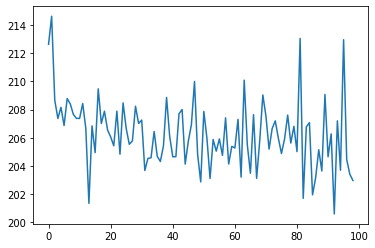

In [11]:
plt.plot(all_losses[1:])

In [46]:
def evaluate(trained_rnn, track_id):
    hidden = rnn.init_hidden()
    waveform = get_waveform(track_id)

    for val in waveform:
        output, hidden = trained_rnn(torch.tensor([[val]]), hidden)
    
    return output

confusion_mat = torch.zeros(len(all_genres), len(all_genres))
n_confusion = len(test_tracks)

progress = 0
for track in test_tracks.iterrows():
    progress += 1
    if progress % 50 == 0:
        diagonal = confusion_mat.diag()
        print(f"{round(progress / len(test_tracks) * 100, 1)}%: Accuracy of {round(diagonal.sum().item() / confusion_mat.sum().item(), 4)}")
    output = evaluate(rnn, track[0])
    genre_i, genre = output_genre(output)
    confusion_mat[all_genres.index(track[1]["genre_top"])][genre_i] += 1

for i in range(len(all_genres)):
    confusion_mat[i] = confusion_mat[i] / confusion_mat[i].sum()

3.1%: Accuracy of 0.2
6.2%: Accuracy of 0.2
9.4%: Accuracy of 0.2


KeyboardInterrupt: 

In [38]:
a = torch.zeros(4, 4)
a[0][0] = 4
round(a.sum().item(), 1)

4.0